# Imports

In [1]:
import pandas as pd
import numpy as np
import project_functions as pf
import project_models as pm
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# Plotting config
pf.set_plot_config()
# Hide TF messages for neater NB
pf.tf_message_toggle()

In [3]:
# Hyperparams used during modelling
# Compilation hyperparams
compile_hp = dict()
compile_hp["loss"] = "binary_crossentropy"
compile_hp["optimizer"] = optimizers.Adam(learning_rate = 0.001)
compile_hp["metrics"] = ["accuracy"]
compile_hp["maxlen"] = 500

# Fitting hyperparams
fit_hp = dict()
fit_hp["batch_size"] = 64
fit_hp["epochs"] = 100
fit_hp["validation_split"] = 0.3
# Create callback to select the best model
fit_hp["callbacks"] = EarlyStopping(monitor = "val_loss",
                                         mode = "min",
                                         restore_best_weights = True,
                                         patience = 10)

# Eliminate verbose to have a neater notebook 
fit_hp["verbose"] = 0
# fit_hp["steps_per_epoch"] = 10

In [4]:
# Load in data and process it
raw = pf.load_data("Fake.csv", "True.csv")
df = pf.prep_text(raw)

In [5]:
# Split into test and train data
X = df.all_text.values
y = np.array(df["fake_news"], dtype = "float32")
text_train, text_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2, shuffle = True,
                                                          # reproducible split
                                                         random_state = 1)

In [6]:
# Process, tokenize, pad/trim
tokenizer, X_train, X_test = pf.tokenize_padder(text_train, text_test)

# Get vocab size
vocab_size = len(tokenizer.word_index) + 1

In [7]:
# Create dataframe to store each model's results on test set
all_results = pd.DataFrame()

# Embeddings

In [8]:
# Generate the embeddings
embed_dict = dict()
embed_dict["spacy"] = pm.spacy_embedding(tokenizer, show_progress = True, maxlen=compile_hp["maxlen"])
embed_dict["keras"] = pm.keras_embedding(tokenizer, maxlen=compile_hp["maxlen"])

# Create dataframe to store each model's results on test set
all_results = pd.DataFrame()

7.642 % complete
15.285 % complete
22.927 % complete
30.569 % complete
38.211 % complete
45.854 % complete
53.496 % complete
61.138 % complete
68.781 % complete
76.423 % complete
84.065 % complete
91.707 % complete
99.35 % complete


# GRU

## SpaCy Embedding

In [9]:
# Set embedding
embedding_layer = "spacy"
# Toggle batch normalization
batch_normalize = True

# Build and fit model with SpaCy embedding
model = pm.bi_gru(**compile_hp, batch_normalize=batch_normalize,
                  embedding = embed_dict[embedding_layer])
model.summary()
history = model.fit(X_train, y_train, **fit_hp)

# Evalute model with different test metrics
results = pm.get_test_metrics(model, X_test, y_test,
                              history, embedding = embedding_layer,
                              batch_normalize = batch_normalize)
# Concatenate all results
all_results = pd.concat([all_results, results])

Metal device set to: Apple M1
Model: "GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 spacy_embedding (Embedding)  (None, 500, 96)          12561696  
                                                                 
 Bidirectional_GRU (Bidirect  (None, 64)               24960     
 ional)                                                          
                                                                 
 Linear_Dense (Dense)        (None, 256)               16640     
                                                                 
 Batch_Norm1 (BatchNormaliza  (None, 256)              1024      
 tion)                                                           
                                                                 
 ReLU_Activation (Activation  (None, 256)              0         
 )                                                               
                                 

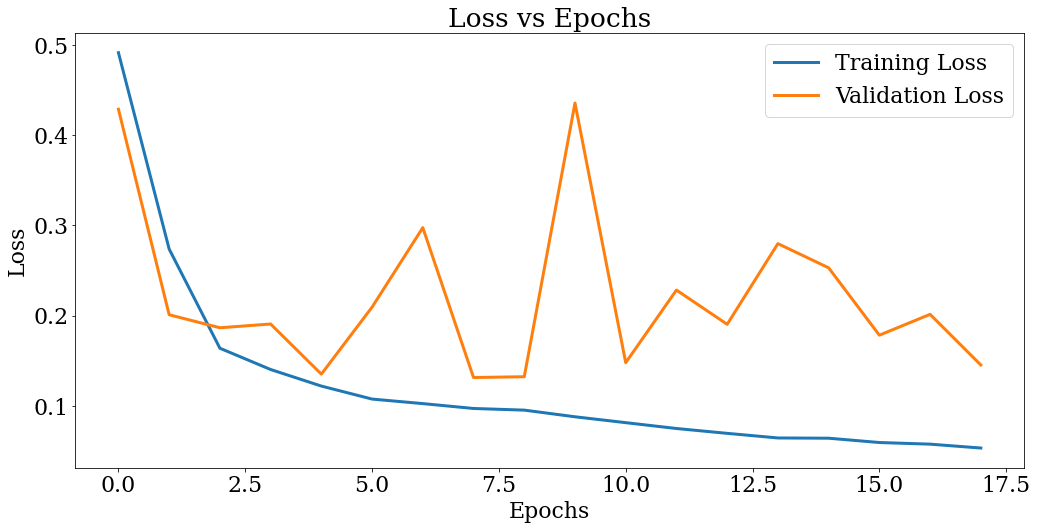

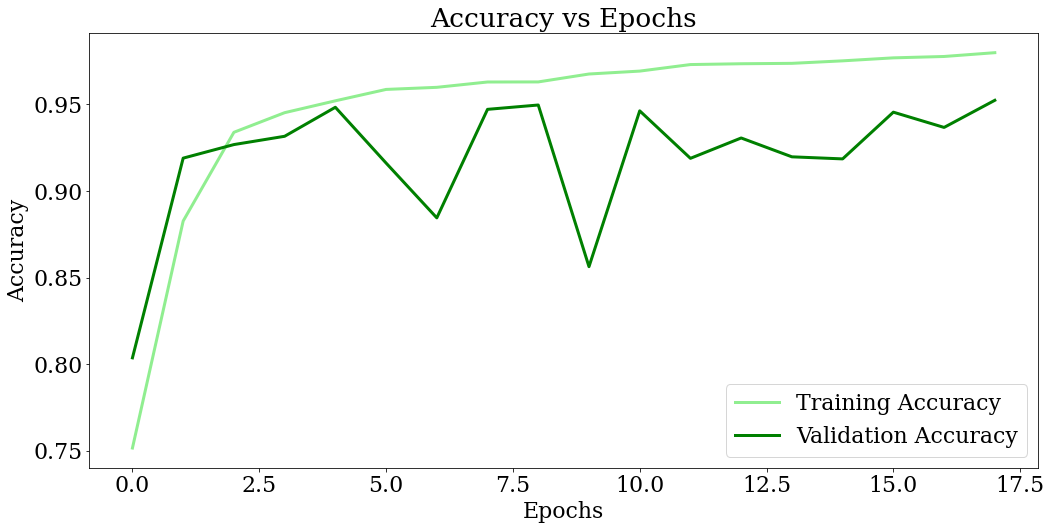

In [10]:
# Plot history
pf.plot_loss(history)
pf.plot_acc(history)

## Keras Embedding

In [11]:
# Set embedding
embedding_layer = "keras"
# Toggle batch normalization
batch_normalize = True

# Build and fit model with Keras embedding
model = pm.bi_gru(**compile_hp, batch_normalize = batch_normalize,
                  embedding = embed_dict[embedding_layer])
model.summary()
history = model.fit(X_train, y_train, **fit_hp)

# Evalute model with different test metrics
results = pm.get_test_metrics(model, X_test, y_test,
                              history, embedding = embedding_layer,
                              batch_normalize = batch_normalize)
# Concatenate all results
all_results = pd.concat([all_results, results])

Model: "GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_embedding (Embedding)  (None, 500, 256)         33497856  
                                                                 
 Bidirectional_GRU (Bidirect  (None, 64)               55680     
 ional)                                                          
                                                                 
 Linear_Dense (Dense)        (None, 256)               16640     
                                                                 
 Batch_Norm1 (BatchNormaliza  (None, 256)              1024      
 tion)                                                           
                                                                 
 ReLU_Activation (Activation  (None, 256)              0         
 )                                                               
                                                               

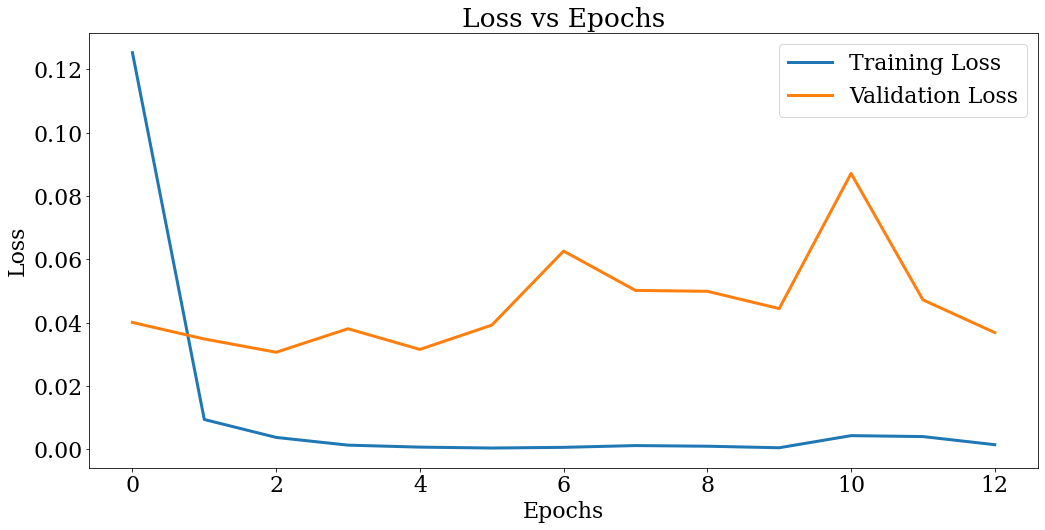

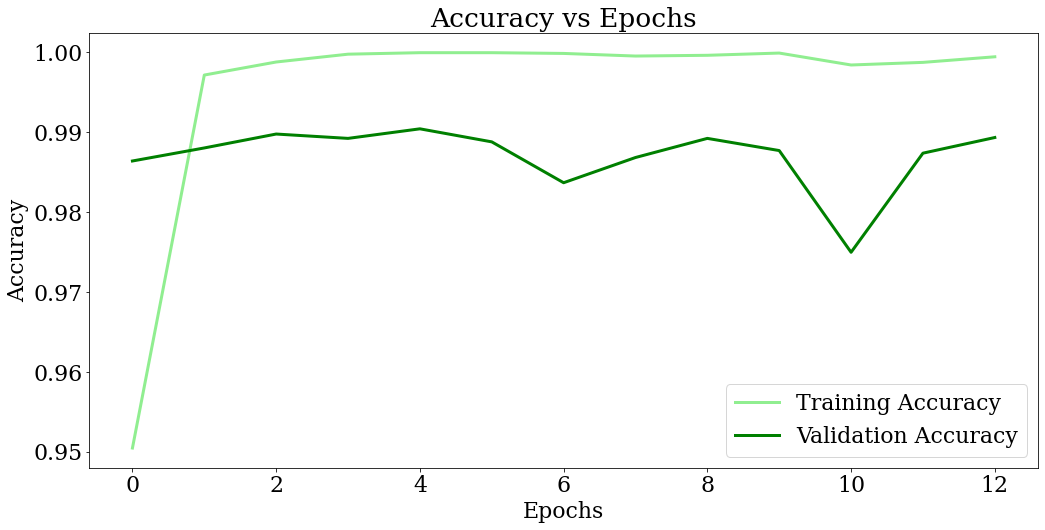

In [12]:
# Plot history
pf.plot_loss(history)
pf.plot_acc(history)

In [13]:
all_results

,embedding,batch_normalize,accuracy,roc_auc,f1,epochs
0,spacy,True,0.948393,0.989899,0.945192,18
0,keras,True,0.991116,0.999493,0.990398,13
